# Jupiter notebook for the sixth seminar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import trange
%config InlineBackend.figure_format = 'svg' 
from pylab import rcParams
rcParams['figure.figsize'] = 8,5
%matplotlib inline

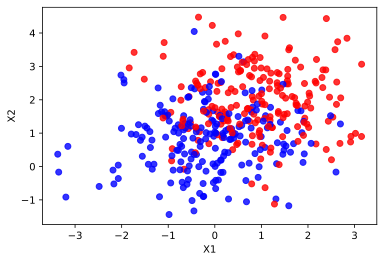

In [2]:
from sklearn.datasets import make_blobs

X_toy, y_toy = make_blobs(n_samples=400,
    centers=[[0., 1.], [1., 2.]], random_state=14)

plt.scatter(X_toy[:, 0], X_toy[:, 1], c=y_toy, alpha=0.8, cmap='bwr')
plt.xlabel('X1'), plt.ylabel('X2')
plt.show()

In [3]:
from sklearn.metrics import accuracy_score

def plot_decision_surface(clf, X, y, nx=200, ny=100, cmap='bwr', alpha=0.6):
    #Plot the decision boundary of clf on X and y, visualize training points
    
    # Define the grid
    x_top_left = X.min(axis=0) - 1
    x_bottom_right = X.max(axis=0) + 1
    grid_x0, grid_x1 = np.meshgrid(
         np.linspace(x_top_left[0], x_bottom_right[0], ny),
         np.linspace(x_top_left[1], x_bottom_right[1], nx)
      )
    
    # Calculate predictions on the grid
    y_pred_grid = clf.predict(
                        np.stack(
                              [
                                grid_x0.ravel(),
                                grid_x1.ravel()
                              ],
                              axis=1
                            )
                      ).reshape(grid_x1.shape)
    
    # Find optimal contour levels and make a filled
    # contour plot of predictions
    labels = np.sort(np.unique(y))
    labels = np.concatenate([[labels[0] - 1],
                             labels,
                             [labels[-1] + 1]])
    medians = (labels[1:] + labels[:-1]) / 2
    plt.contourf(grid_x0, grid_x1, y_pred_grid, cmap=cmap, alpha=alpha,
                 levels=medians)
    
    # Scatter data points on top of the plot,
    # with different styles for correct and wrong
    # predictions
    y_pred = clf.predict(X)
    plt.scatter(*X[y_pred==y].T, c=y[y_pred==y],
                marker='o', cmap=cmap, s=10, label='correct')
    plt.scatter(*X[y_pred!=y].T, c=y[y_pred!=y],
                marker='x', cmap=cmap, s=50, label='errors')

    # Dummy plot call to print the accuracy in the legend.
    plt.plot([], [], ' ',
             label='Accuracy = {:.3f}'.format(accuracy_score(y, y_pred)))
    
    plt.legend(loc='best')

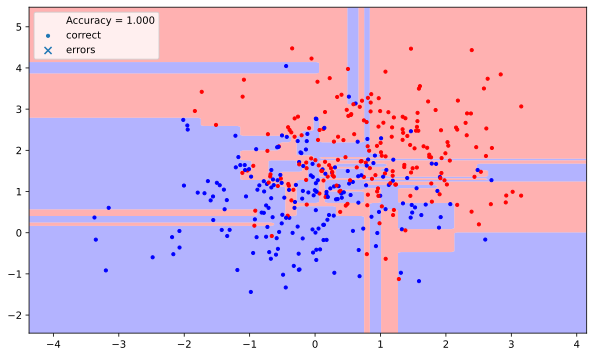

In [4]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_toy,y_toy)
plt.figure(figsize=(10, 6))
plot_decision_surface(model, X_toy, y_toy)

## Decision trees

### Tree depth

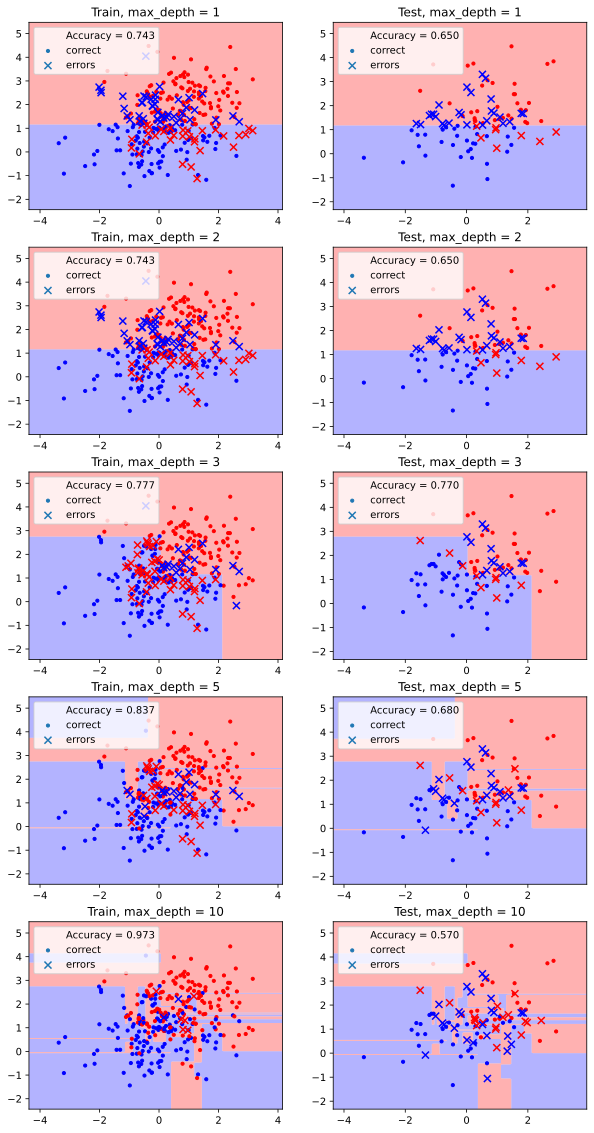

In [5]:
from sklearn.model_selection import train_test_split
X_toy_train, X_toy_test, y_toy_train, y_toy_test = train_test_split(X_toy, y_toy, test_size=0.25)
depth_values = [1, 2, 3, 5, 10]
numberOfRows = len(depth_values)

plt.figure(figsize = (10,20))
for i in range(numberOfRows):
    plt.subplot(numberOfRows, 2, 2*i + 1)
    model = DecisionTreeClassifier(max_depth=depth_values[i])
    model.fit(X_toy_train, y_toy_train)
    plt.title("Train, max_depth = {0}".format(depth_values[i]))
    plot_decision_surface(model, X_toy_train, y_toy_train)
    plt.subplot(numberOfRows, 2, 2*i+2)
    plt.title("Test, max_depth = {0}".format(depth_values[i]))
    plot_decision_surface(model, X_toy_test, y_toy_test)
    
plt.show()

### Toy multiclass data

In [6]:
!wget https://github.com/HSE-LAMBDA/MLatFIAN2021/raw/main/seminar06/data.npz

--2021-11-11 21:50:40--  https://github.com/HSE-LAMBDA/MLatFIAN2021/raw/main/seminar06/data.npz
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HSE-LAMBDA/MLatFIAN2021/main/seminar06/data.npz [following]
--2021-11-11 21:50:41--  https://raw.githubusercontent.com/HSE-LAMBDA/MLatFIAN2021/main/seminar06/data.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108474 (106K) [application/octet-stream]
Saving to: ‘data.npz.1’

data.npz.1          100%[===================>] 105.93K  --.-KB/s    in 0.05s   

2021-11-11 21:50:41 (1.93 MB/s) - ‘data.npz.1’ saved [108474/108474]



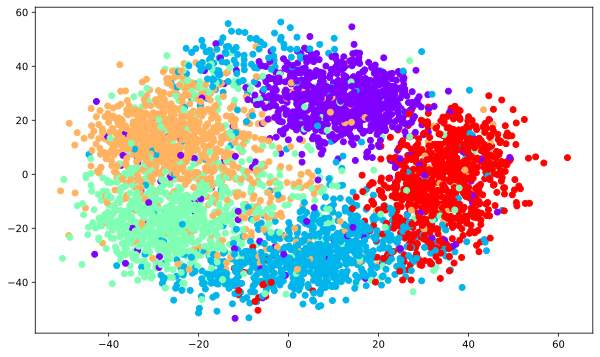

In [7]:
data = np.load('data.npz')
X, y = data["X"], data["y"]

plt.figure(figsize=(10, 6))
plt.scatter(X[:,0], X[:,1], c=y, cmap="rainbow")
plt.show()

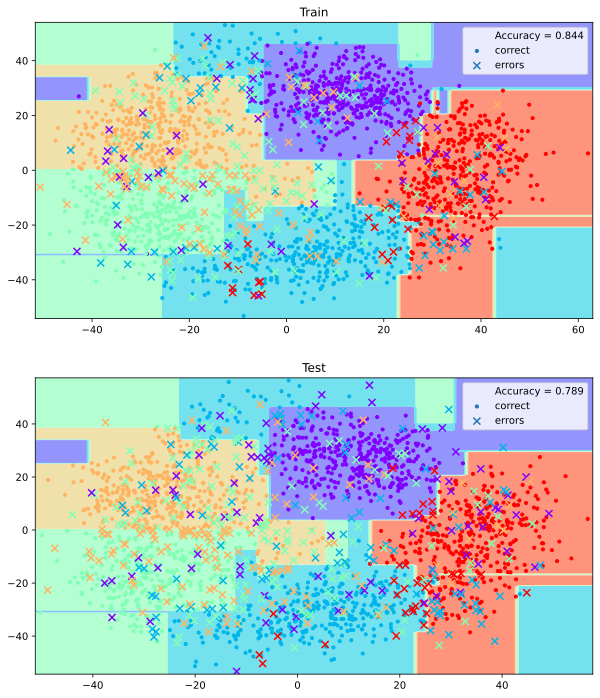

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1337)
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X_train, y_train)

plt.figure(figsize=(10, 12))
plt.subplot(2, 1, 1)
plt.title("Train")
plot_decision_surface(clf, X_train, y_train, cmap='rainbow')
plt.subplot(2, 1, 2)
plt.title("Test")
plot_decision_surface(clf, X_test, y_test, cmap='rainbow')
plt.show()

### Feature transformations

Data is clustered in a manner that it may be possible to better classificate it by the angle.

In [9]:
def SinCos(X):
    x = X[:,0]
    y = X[:,1]
    absolute = np.sqrt(x**2+y**2)+0.0001
    a = y / np.sqrt(x**2+y**2)
    b = x / np.sqrt(x**2+y**2)
    a = a[:,None]
    b = b[:,None]
    return np.concatenate((a, b), axis=1)

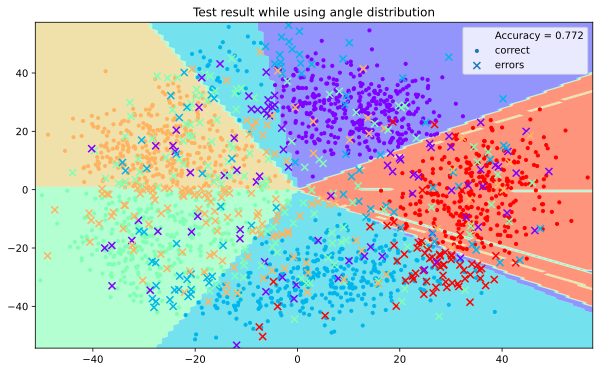

In [10]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

model = make_pipeline(
    FunctionTransformer(SinCos),
    DecisionTreeClassifier(max_depth=4)
)
model.fit(X_train, y_train)

plt.figure(figsize=(10,6))
plt.title("Test result while using angle distribution")
plot_decision_surface(model, X_test, y_test, cmap='rainbow')

Also, we didn't apply any feature scaling while working with decision trees. That's because they don't need it to work normally: they compare features with some threshold, if we scale features, that will just scale these thresholds. That's why scaling doesn't change anything.

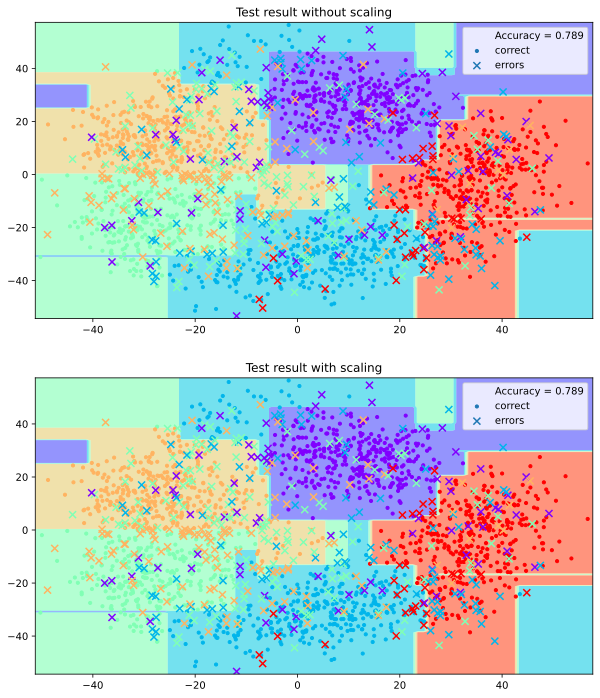

In [11]:
from sklearn.preprocessing import StandardScaler

model1 = DecisionTreeClassifier(max_depth=6)
model2 = make_pipeline(
                StandardScaler(),
                DecisionTreeClassifier(max_depth=6)
            )
model1.fit(X_train,y_train)
model2.fit(X_train,y_train)

plt.figure(figsize=(10,12))
plt.subplot(2, 1, 1)
plt.title("Test result without scaling")
plot_decision_surface(model1, X_test, y_test, cmap="rainbow")
plt.subplot(2, 1, 2)
plt.title("Test result with scaling")
plot_decision_surface(model2, X_test, y_test, cmap="rainbow")

### Tree pruning

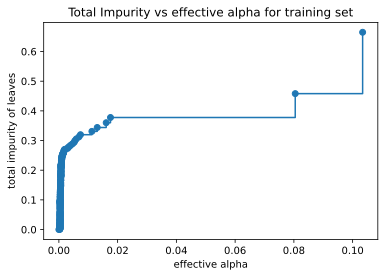

In [12]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

path = model.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")
plt.title("Total Impurity vs effective alpha for training set")
plt.show()

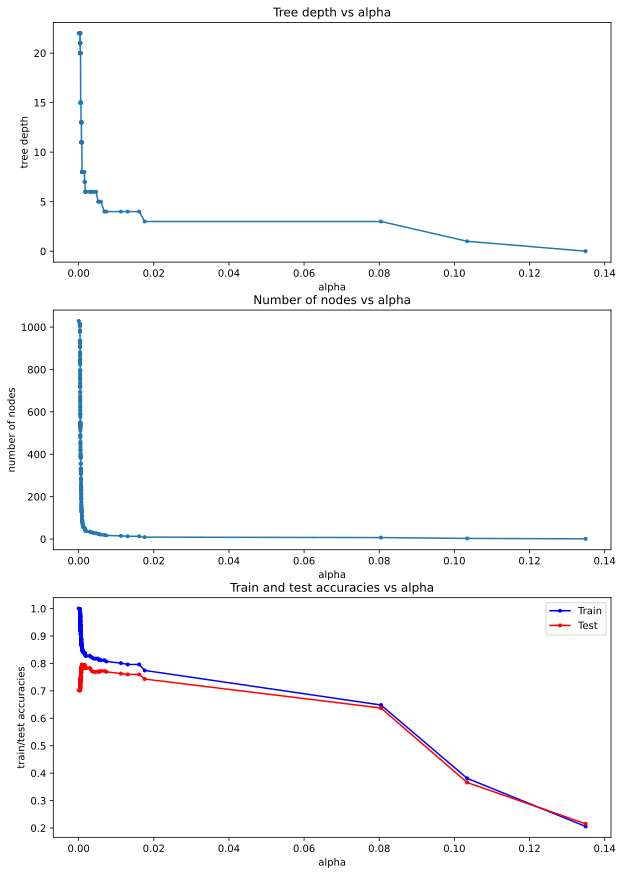

In [13]:
depthOfModel = []
nodesOfModel = []
trainAccuracies = []
testAccuracies = []

for alpha in ccp_alphas:
    model = DecisionTreeClassifier(ccp_alpha=alpha)
    model.fit(X_train, y_train)
    depthOfModel.append(model.tree_.max_depth)
    nodesOfModel.append(model.tree_.node_count)
    trainPrediction = model.predict(X_train)
    testPrediction = model.predict(X_test)
    trainAccuracies.append(accuracy_score(y_train, trainPrediction))
    testAccuracies.append(accuracy_score(y_test, testPrediction))
    
plt.figure(figsize=(10,15))
plt.subplot(3, 1, 1)
plt.title("Tree depth vs alpha")
plt.xlabel("alpha")
plt.ylabel("tree depth")
plt.plot(ccp_alphas, depthOfModel, marker=".")

plt.subplot(3, 1, 2)
plt.title("Number of nodes vs alpha")
plt.xlabel("alpha")
plt.ylabel("number of nodes")
plt.plot(ccp_alphas, nodesOfModel, marker=".")

plt.subplot(3, 1, 3)
plt.title("Train and test accuracies vs alpha")
plt.xlabel("alpha")
plt.ylabel("train/test accuracies")
plt.plot(ccp_alphas, trainAccuracies, marker=".", c="blue", label="Train")
plt.plot(ccp_alphas, testAccuracies, marker=".", c="red", label="Test")
plt.legend()
plt.show()

## California housing

In [14]:
from sklearn.datasets import fetch_california_housing

dataset = fetch_california_housing()

data = pd.DataFrame(dataset.data, columns=dataset.feature_names)
data['target'] = dataset.target

print(len(data))
data.head(10)

20640


MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
5  4.0368      52.0  4.761658   1.103627       413.0  2.139896     37.85   
6  3.6591      52.0  4.931907   0.951362      1094.0  2.128405     37.84   
7  3.1200      52.0  4.797527   1.061824      1157.0  1.788253     37.84   
8  2.0804      42.0  4.294118   1.117647      1206.0  2.026891     37.84   
9  3.6912      52.0  4.970588   0.990196      1551.0  2.172269     37.84   

   Longitude  target  
0    -122.23   4.526  
1    -122.22   3.585  
2    -122.24   3.521  
3    -122.25   3.413  
4    -122.25   3.422  
5    -122.25   2.697  
6    -122.25   2.992  
7    -122.25   2.414  
8    -122.26   2.267  
9    -122.25   2.611

In [15]:
print(dataset.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [16]:
X, y = data.drop('target', axis=1), data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)

In [17]:
np.array(X_train["Latitude"])

array([34.57, 38.14, 33.89, ..., 33.91, 37.47, 37.99])

In [18]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

In [19]:
numberOfNeighbors = 10
numberOfTrees = 100
minNumberOfSamplesAtLeaf = 3
maxDepthOfTrees = 6

neighborsColumnTransformer = make_column_transformer(("passthrough", ["Latitude", "Longitude"]))
forestColumnTransformer = make_column_transformer(("drop", ["Latitude", "Longitude"]), remainder="passthrough")

model1 = make_pipeline(
                neighborsColumnTransformer,
                KNeighborsRegressor(n_neighbors=numberOfNeighbors)
        )
model2 = make_pipeline(
                forestColumnTransformer,
                RandomForestRegressor(max_depth=maxDepthOfTrees, min_samples_leaf=minNumberOfSamplesAtLeaf)
        )

models = [
    ("neighbors", model1),
    ("forest", model2)
]
final_model = LinearRegression()
model3 = StackingRegressor(estimators=models, final_estimator=final_model, cv=5)

model1.fit(X_train, y_train)
predictions1 = model1.predict(X_test)
print("KNN predicts with {0:.3f} error".format(mean_squared_error(y_test, predictions1)))

model2.fit(X_train, y_train)
predictions2 = model2.predict(X_test)
print("Random forest predicts with {0:.3f} error".format(mean_squared_error(y_test, predictions2)))

model3.fit(X_train, y_train)
predictions3 = model3.predict(X_test)
print("Linear regression after composition of KNN and random forest predicts with {0:.3f} error".format(
    mean_squared_error(y_test, predictions3)))

KNN predicts with 0.309 error
Random forest predicts with 0.462 error
Linear regression after composition of KNN and random forest predicts with 0.235 error
